In [37]:
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [12]:
df = spark.read.format('csv').option('header', 'true').load('C://Users/Uldum/Downloads/clustering_test_work.csv', inferSchema =True)

In [17]:
# грузим датасет, дропаем ненужные колонки, фильтруем по последней дате наблюдений, дропаем дубликаты, смотрим
df = df.drop('_c0', 'actual_id').filter(F.col('period_end') == '2022-12-07')
df = df.dropDuplicates()
df.show(1, vertical = True, truncate=False)

-RECORD 0----------------------------------
 period_end          | 2022-12-07 00:00:00 
 num                 | 12                  
 revenue_lastyear    | 0.0                 
 quantity_lastyear   | 0                   
 orders_lastyear     | 0                   
 orders_refund       | 0                   
 ratio_not_dh        | 0.0                 
 ratio_online        | 0.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 1.0                 
 quantity_1st_period | 2.0                 
 unigenders          | 1                   
 recency             | 695                 
 aov                 | 0.0                 
only showing top 1 row



In [18]:
# по итогда карты корреляций, дропаем ещё пару столбцов
df = df.drop('period_end', 'ratio_not_dh')

In [19]:
df_new = df

<AxesSubplot: >

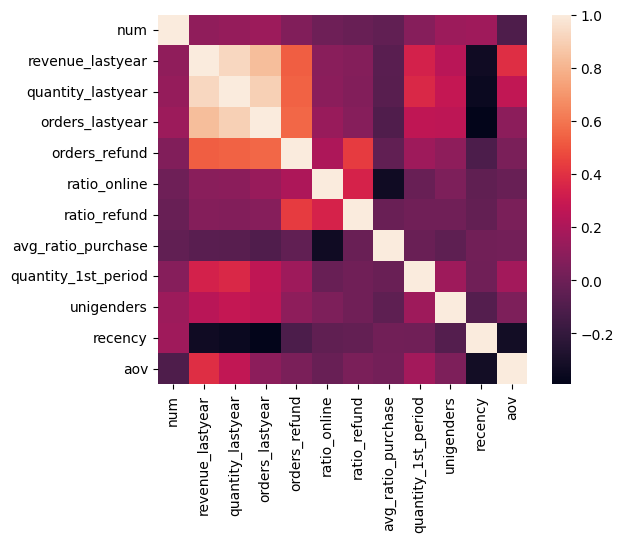

In [20]:
# карта корреляций
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_new.columns, outputCol=vector_col)
df_vector = assembler.transform(df_new).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

corr = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr_1 = corr.reshape(int(len(corr)**0.5), int(len(corr)**0.5))
sns.heatmap(corr_1, square = True, xticklabels = df_new.columns, yticklabels = df_new.columns)

In [22]:
# вытягиваем фичи (при кластеризации это все оставшиеся в датасете колонки) в 1 вектор-кортеж
assembler = VectorAssembler(inputCols = df_new.columns, outputCol = 'features')
output = assembler.transform(df_new)
output.show(1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------
 num                 | 12                                         
 revenue_lastyear    | 0.0                                        
 quantity_lastyear   | 0                                          
 orders_lastyear     | 0                                          
 orders_refund       | 0                                          
 ratio_online        | 0.0                                        
 ratio_refund        | 0.0                                        
 avg_ratio_purchase  | 1.0                                        
 quantity_1st_period | 2.0                                        
 unigenders          | 1                                          
 recency             | 695                                        
 aov                 | 0.0                                        
 features            | (12,[0,7,8,9,10],[12.0,1.0,2.0,1.0,695.0]) 
only showing top 1 row



In [25]:
# проводим скалирование значений фичей
scaler = StandardScaler(inputCol='features', outputCol="scaledFeatures",
                                withStd=True, withMean=True)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
scaledData.show(1, vertical = True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 num                 | 12                                                                                                                                                                                                                                             
 revenue_lastyear    | 0.0                                                                                                                                                                                                                                            
 quantity_lastyear   | 0                                                                                                                                                                                           

In [27]:
# оставляем только колонку с отскалированными фичами
data = scaledData.select(F.col('scaledFeatures').alias('features'))
data.show(1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 features | [1.0017350740187279,-0.5159952844901173,-0.6113354228736306,-0.69187811874539,-0.18322753811857184,-0.7633261253644211,-0.26886183540991143,0.3032341784915757,-0.2818644822252958,-0.3050294456475256,3.4249944791273483,-1.0663461161601016] 
only showing top 1 row



Text(0, 0.5, 'Silhouette Score')

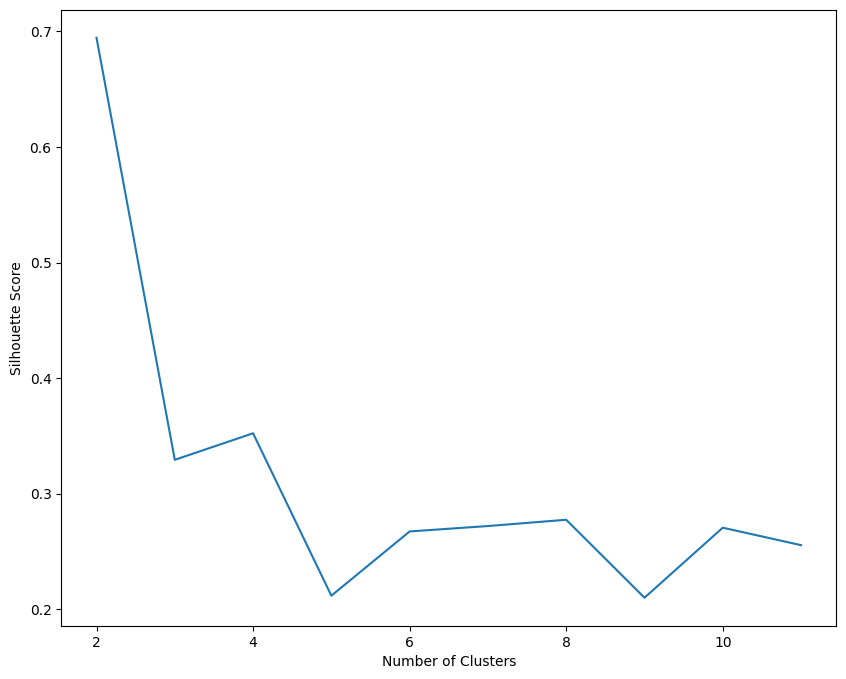

In [38]:
# используем метод локтя, чтобы найти оптимальное число кластеров. Метрика - силуэт
# по итогу получим график зависимости значения силуэта от числа кластеров. Выберем максимум или около того
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
for K in range(2,12):
    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)
    BKMeans_fit=BKMeans_.fit(data)
    BKMeans_transform=BKMeans_fit.transform(data) 
    evaluation_score=evaluator.evaluate(BKMeans_transform)
    silhouette_scores.append(evaluation_score)


fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,12),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [39]:
# определим модель кластеризации и обучим её
bkm = BisectingKMeans().setK(4).setSeed(13)
model = bkm.fit(data)

In [40]:
# выведем номера кластеров рядом с каждой строкой. Это не совсем предсказания, просто нумерация того, что произошло на
# прошлом шаге
predictions = model.transform(data)

In [42]:
# выведем несколько значений посмотреть
predictions.show(10)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.00173507401872...|         0|
|[-0.3009212851307...|         1|
|[-0.8219838287905...|         0|
|[-0.8219838287905...|         0|
|[1.00173507401872...|         0|
|[-0.3009212851307...|         0|
|[-0.0403900133008...|         0|
|[-1.0825151006204...|         1|
|[-0.3009212851307...|         0|
|[1.52279761767852...|         0|
+--------------------+----------+
only showing top 10 rows



In [43]:
# выведем число объектов, попавших в каждый кластер (или размеры кластеров)
predictions.groupby('prediction').count().show(5)

+----------+------+
|prediction| count|
+----------+------+
|         1| 44141|
|         3|   582|
|         2| 14244|
|         0|110446|
+----------+------+



In [ ]:
# определим оценщик качества модели
evaluator = ClusteringEvaluator()

In [44]:
# по умолчанию используется метрика силуэт, закинем в оценщик размеченные данные и выведем показатель метрики
silhouette = evaluator.evaluate(predictions)

In [45]:
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.35256618767326314


In [46]:
# координаты центров всех 4х кластеров в многомерном пространстве фичей
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[-0.03724796 -0.19460756 -0.20145849 -0.21330582 -0.1749736  -0.61822363
 -0.25857562  0.30189154 -0.06247102 -0.11672068  0.08734501 -0.06027155]
[-0.08944362 -0.19183973 -0.20761738 -0.14634687  0.11241499  1.40974409
  0.54490623 -0.64707198 -0.21062811 -0.11985705  0.08320048 -0.13117478]
[ 0.53179082  1.71617625  1.82624607  1.73564549  0.66531833  0.38415891
  0.27173035 -0.31603519  1.01069278  1.20029301 -0.88781285  0.83922447]
[ 0.83501284  9.42538277  9.23033868  9.04962518  8.34281823  0.99384016
  1.08617214 -0.47776015  3.07976946  1.85967579 -1.15529825  0.84706558]


In [ ]:
Что можем увидеть из этих координат? Если начнём сравнивать по фичам каждый массив (первое значение с первым, второе
со вторым), то заметим по каким фичам кластеры отличаются друг от друга.